In this lecture, we embark on the journey of studying recurrent neural networks (RNNs).

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

In [4]:
path="C:\\Users\\gao\\GAO_Jupyter_Notebook\\Datasets"
os.chdir(path)

#path="C:\\Users\\pgao\\Documents\\PGZ Documents\\Programming Workshop\\PYTHON\\Open Courses on Python\\Udemy Course on Python\Introduction to Data Science Using Python\\datasets"
#os.chdir(path)

#### I. Overview of RNNs

Sequence models are a special class of deep neural networks that have applications in machine translation, speech recognition, image captioning, music generation, etc.. Sequence problems can be of varying types where the input $X$ and output $y$ might both be sequences with either the same length or different lengths. It can also be that only one of $X$ or $y$ is a sequence.

A recurrent neural network (RNN) is a variation of a basic fully-connected feedforward neural network. RNNs are good for processing sequential data such as natural language processing and audio recognition. Recall that the basic neural network architecture, neural nets are trained with 3 basic steps:

   1. A forward pass that makes a prediction.
   2. A comparison of the prediction to the ground truth using a loss function. The loss function outputs an error value.
   3. Using that error value, perform back propagation which calculates the gradients for each node in the network.
   
In contrast, an RNN contains a hidden state that is feeding it information from previous states. Below, we see the red unit represents the input; the black unit represents the output; and the blue unit represents the hidden layer:

In [18]:
from IPython.display import Image
Image(url='https://miro.medium.com/max/342/0*3htVyljT69LGMnml.gif', width=150, height=150) 

The concept of a hidden state is analogous to integrating sequential data in order to make a more accurate prediction, and this concept is called **sequential memory**. Consider how much easier it is to predict the motion of a ball if your data is still shots of the ball in motion. With no sequence information, it is impossible to predict where it is moving, in contrast, if you know the previous locations, predictions will be more accurate. The same logic is applicable to estimating the next word in a sentence, or the next piece of audio in a song. This information is the hidden state, which is a representation of previous inputs. Below is an illustration of pseudo-code for RNN to predict words in a sequence:

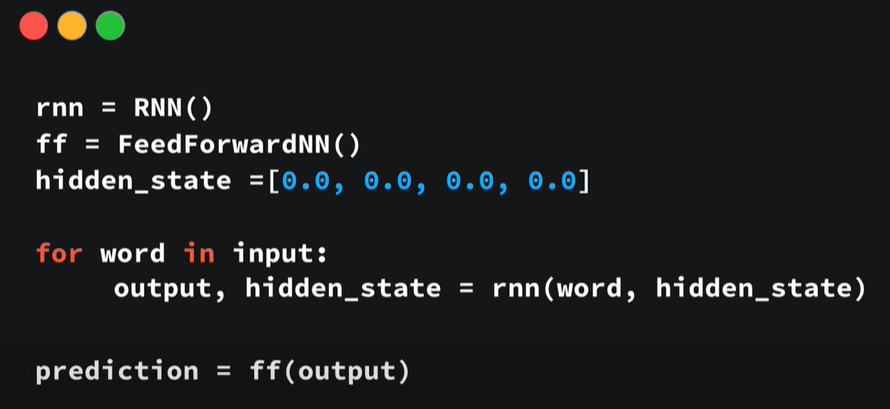

In [5]:
from IPython.display import Image
Image("pseudo code for RNN.PNG", height=250, width=250)

Before we proceed, the first question we should ask is: why do we even need RNNs for this type of problems? Suppose we have a named entity recognition problem where $X$ is an input sentence like "Jack and Jill went up the hill..." and $y$ is an output representing whether each input word is a person's name or not. So, essentially $y_{1}, y_{2},...$ will be 1 if it is a persons name and 0 otherwise. And $x_{1}, x_{2},...$ will be vectors of length 10000 assuming our dictionary contains 10000 words. For example, if 'Jack' comes at the 3200th position in our dictionary, $x_{1}$ will be a vector of length 10000 containing a 1 at the 3200th position and 0 everywhere else. There might be a case that a word in the input sequence is not present in our dictionary and for that, we can use a separate token like 'unknown'.

Suppose we use a standard neural network and has the seven words in our case as input in the form of seven one-hot vectors into a standard neural network followed by some hidden layers and a softmax layer, in the end, to predict whether each word is a person’s name or not by having 0 or 1 as an output. But this approach has two problems, one is that the input can have different lengths for different examples in which case a standard neural network will not work. Secondly, a naive architecture such as this does not share features appearing across the different position of texts. For example, if the network has learned that Jack appearing in the first position of the text is a person's name, it should also recognise Jack as a person's name if it appears in any other position. 

For this reason, we want to invoke RNN for our learning problem. RNN is a natural way to tackle any of those questions that are 'sequential' in nature (or the problem intrinsically has an embedded notion of natural order, say time) because of how RNN uses the notion of memory. However, simple RNNs are not perfect, as it suffers from short-term-memory problems. Mathematically, this is called the **vanishing gradient problem (VGP)**. To illustrate this problem, consider predicting a sentence "_Jessica_ loves piano music, particular music written by Schubert and Chopin; moreover, _her_ husband is a classical pianist." The pronoun _her_ refers to _Jessica_. It's contextual. But the word _her_ is not following the word _Jessica_ immediately, so the computer may not be able recognize, or remember the context prior to the invocation of the pronouns. In other words, as the these 2 words drift too apart, it will make the gender recognition harder. Intuitively, when we have very deep RNNs with several time steps, it is difficult for the errors associated with the later time steps to affect the computations of the earlier time steps. Thus the nature of the problem is really short-memory. Mathematically, to train an RNN, we use an application of back-propagation called **back-propagation through time (BPTT)**. Since the weights at each layer are tuned via the chain rule, their gradient values will exponentially shrink as it propagates through each time step, eventually 'vanishing'. 

There is another problem we can also run into in simple RNNs; it's called the **exploding gradient problem (EGP)** where our parameters become very large and don't converge. This is the opposite problem of VGP. However, EGP can be solved by **gradient clipping**. The gradient clipping idea utilizes the concept that if $g$ is a gradient and $||g||>\eta$ for some real number $\eta>0$, we can set $g^{(s+1)}=\frac{\eta g}{||g^{(s)}||}$ for step $s$. Basically, we prevent gradients from blowing up by rescaling them so that their norm is at most a particular value $\eta$. This certainly biases the training procedure, since the resulting values won't actually be the gradient of the cost function. However, this bias is worth it if it keeps things stable. The following figure shows an exapmle with a cliff and a narrow valley: if happen to land on the face of the cliff, you take a huge step which propels you outisde the good region (even though the unbiased gradient points you to that direction). With gradient clippping, you can stay within the valley:

In [7]:
from IPython.display import Image
Image(url='https://miro.medium.com/max/1400/1*vLFINWklJ0BtYtgzwK223g.png', width=300, height=300) 

Generally speaking, VGP is a more common and much harder problem to solve compared to EGP. And to solve the former, the solutions are **gated recurrent units (GRUs)** and **long-short-term-memory models (LSTMs)**. We will discuss these topics moving forward. Here are what they look conceptually:

In [5]:
from IPython.display import Image
Image(url='https://miro.medium.com/max/958/1*yBXV9o5q7L_CvY7quJt3WQ.png', width=500, height=500) 

#### II. Simple RNNs and Recurrent Layers in Keras

Before we study LSTM and GRU, we need to look at the defects of the simple RNA first. Let's implement a simple RNN model. Recall that RNNs process sequences by iterating through the sequence elements and maintaining a state containing information relative to what it has seen so far. An RNN is a type of ANN that has an internal loop. The state of the RNN is reset between processsing two different, independent sequences (such as 2 different IMDB reviews), so we will consider one sequence a single data point: a single input to the network. What changes is that this data point is no longer processed in a single step; rather, the network internally loops over sequence elements. 

To make the notions of loop and state clear, let's implement the forward pass step of a toy RNN model using plain Python coding. This RNN takes as input a sequence of vectors, which we will encode as a 2D tensor of size (_timesteps_, _input\_features_). It loops over time steps, and at each time step, it considers its current state at $t$ and the input at $t$, and combines them to obtain the output at $t$. We will then set the state for the next step to be this previous output. For the first time step, the previous output isn't defined; hence there is no current state. We will initialize the state as an all-zero vector. In pseudocode, this is what RNN looks like: 

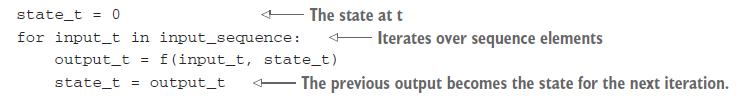

In [6]:
from IPython.display import Image
Image("RNN pseudocode 1.PNG", height=500, width=500)

From above, the function $f(.)$ is the transformation of the input and state into an output. We can parametrize this function with 2 types of matrices $W, U$ and a bias vector $b$. It's similar to the transformation operated by a densely connectd layer in a feedforward network. The activation function (see below) can be something like $tanh(.)$:

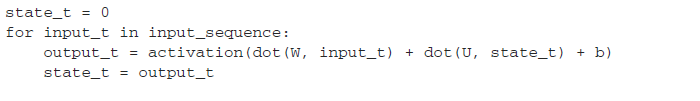

In [7]:
from IPython.display import Image
Image("RNN pseudocode 2.PNG", height=500, width=500)

Keras has a SimpleRNN() layer that can be invoked, just like the Dense() layer or Embedding() layer. Chollet (2018) has a nice example using SimpleRNN() to build a model on the movie review IMDB dataset (for classification). But as we can imagine, the result won't be satisfactory because of VGP. 

Here is a gif version of the simple RNN mechanism through visualization. Suppose we have a sequence of words. First words get transformed into machine-readable vectors. Then the RNN processes the sequence of vectors one by one like the following. An RNN essentially can be thought of as multiple copies of the same network, each passing a message to a successor (this is what some people call **unrolling the RNN graph**:

In [8]:
from IPython.display import Image
Image(url='https://miro.medium.com/max/958/1*AQ52bwW55GsJt6HTxPDuMA.gif', width=600, height=600) 

Here is a static picture of how an RNN network is unrolled:

In [9]:
Image(url='https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png', width=300, height=300) 

While processing, it passes the previous hidden state ($h_{t}$ denotes hidden state at time $t$) to the next step of the sequence. The hidden state acts as the neural networks memory. It holds information on previous data the network has seen before.

In [9]:
from IPython.display import Image # this is the forget gate for LSTM
Image(url='https://miro.medium.com/max/958/1*o-Cq5U8-tfa1_ve2Pf3nfg.gif', width=600, height=600) 

Let’s look at a cell of the RNN to see how we would calculate the hidden state. First, the input and previous hidden state are combined to form a vector. That vector now has information on the current input and previous inputs. The vector goes through the $tanh(.)$ activation, and the output is the new hidden state, or the memory of the network:

In [10]:
from IPython.display import Image # this is the forget gate for LSTM
Image(url='https://miro.medium.com/max/958/1*WMnFSJHzOloFlJHU6fVN-g.gif', width=600, height=600) 

As we see from above, the central challenge of simple RNN models is the following: can we retain some memories from previous states so that we don't forget things easily? It turns out that both LSTM and GRU have internal mechanisms called **gates** that can regulate the flow of information These gates can learn which data in a sequence is important to keep or throw away. By doing that, it can pass relevant information down the long chain of sequences to make predictions. Almost all state-of-the-art results based on recurrent neural networks are achieved with these two types of networks.

#### III. LSTM

An LSTM has a similar control flow as a recurrent neural network. It processes data passing on information as it propagates forward. The differences are the operations within the LSTM’s cells. Here is what an LSTM cell looks like:

In [22]:
from IPython.display import Image # this is the forget gate for LSTM
Image(url='https://miro.medium.com/max/3285/1*0f8r3Vd-i4ueYND1CUrhMA.png', width=500, height=500)

As you see the main difference is that there is a concept of "conveyor's belt" similar to what you see in the airport. The "belt" essentially allows transportation of long-term memory from the distance to proximity. On top of these, we also need some control to tell us which information gets kept and which gets thrown away. These two core concepts are called **cell states** and **gates**:
   
   1. The cell state acts as a transport highway (conveyor belt) that transfers relative information all the way down the sequence chain. You can think of it as the actual 'memory' of the network. The cell state, in theory, can carry relevant information throughout the processing of the sequence. So even information from the earlier time steps can make it’s way to later time steps, reducing the effects of short-term memory. As the cell state goes on its journey, information get's added or removed to the cell state via gates. This conveyor belt runs straight down the entire chain, with only some minor linear interactions.
   2. The gates are different neural structures that regulate and decide which information is allowed on the cell state. The gates can learn what information is relevant to keep or forget during training. Gates contains sigmoid activations. A sigmoid activation (see below) is similar to the hyperbolic tangent activation. Instead of squishing values between -1 and 1, it squishes values between 0 and 1. That is helpful to update or forget data because any number getting multiplied by 0 is 0, causing values to disappears or be 'forgotten'. Any number multiplied by 1 is the same value therefore that value stay's the same or is kept. The network can learn which data is not important therefore can be forgotten or which data is important to keep.

In [2]:
from IPython.display import Image # sigmoid function
Image(url='https://miro.medium.com/max/958/1*rOFozAke2DX5BmsX2ubovw.gif', width=400, height=400)

So now back to the intuition of LSTM, we need three different gates that regulate information flow in an LSTM cell: a **forget gate**, an **input gate**, and an **output gate**. Intuitively, we need to forget irrelevant information in the carry dataflow, and we need to provide information about the present, then updating the carry track with new information. The LSTM layer is essentially a variant of the simple RNN layer: it adds a way to carry information across many time steps. Information from the sequence can jump onto the conveyor belt at any point, be transported to a later time step, and jump off intact. These gates regulate the aforementioned behaviors. 

Let’s dig a little deeper into what the various gates are doing. Define the values at different times steps $C_{t}$ (carry). This information will have the following impact on the cell: it will be combined with the input conection and the recurrent connection via a dense transformation: a dot product with a weight matrix followed by a bias term and the application of an activation function $a(.)$, and it will affect the state $h_{t}$ being sent to the next step. 

First, we have the forget gate. This gate decides what information should be thrown away or kept. Information from the previous hidden state and information from the current input is passed through the sigmoid function. Values come out between 0 and 1. The closer to 0 means to forget, and the closer to 1 means to keep:

  - $f_{t}=a(U_{f}h_{t-1}+W_{f}x_{t}+b_{f})$ (this is the forget gate, activation using sigmoid)

In [1]:
from IPython.display import Image # this is the forget gate for LSTM
Image(url='https://miro.medium.com/max/3285/1*GjehOa513_BgpDDP6Vkw2Q.gif', width=400, height=00) 

To update the cell state (to decide what new information we are going to store in the cell state), we have to use the input gate. First, a sigmoid layer called the input gate layer decides which value we will update. Next, a hyperbolic tangent layer creates a vector of new candidate values (in the picture below, the tilda $\tilde{C_{t}}$ represents 'candidate'; in this note the 'candidate' is represented by $k_{t}$) that could be added to the state:

   - $i_{t}=a(U_{i}h_{t-1}+W_{i}x_{t}+b_{i})$ (this is the input gate, activation using sigmoid)
   - $k_{t}=a(U_{k}h_{t-1}+W_{k}x_{t}+b_{k})$ (this is the candiate, activation using hypergolic tangent)

In [24]:
from IPython.display import Image # this is the input gate for LSTM
Image(url='https://miro.medium.com/max/958/1*TTmYy7Sy8uUXxUXfzmoKbA.gif', width=500, height=500)

Now we should have enough information to calculate the cell state. First, the cell state gets pointwise multiplied by the forget vector. This has a possibility of dropping values in the cell state if it gets multiplied by values near 0. Then we take the output from the input gate and do a pointwise addition which updates the cell state to new values that the neural network finds relevant. That gives us our new cell state:

   - $C_{t}=i_{t} \oslash k_{t}+C_{t-1} \oslash f_{t}$ with "$\oslash$' denoting element-wise multiplication (Hadamard product).

In [14]:
from IPython.display import Image # this is the cell state for LSTM
Image(url='https://miro.medium.com/max/958/1*S0rXIeO_VoUVOyrYHckUWg.gif', width=600, height=600)

Last we have the output gate. The output gate decides what the next hidden state should be eventually. Remember that the hidden state contains information on previous inputs. First, we pass the previous hidden state and the current input into a sigmoid function. Then we pass the newly modified cell state to the $tanh(.)$ function. We multiply the $tanh(.)$ output with the sigmoid output to decide what information the hidden state should carry. The final output is the hidden state. The new cell state and the new hidden state is then carried over to the next time step:

   - $o_{t}=a(U_{o}h_{t-1}+W_{o}x_{t}+b_{o})$ ($o$ stands for output, activation using sigmoid)
   - $h_{t}=o_{t} \oslash a(C_{t})$ (usually we use hyperbolic tangent)

In [8]:
from IPython.display import Image # this is the output gate for LSTM
Image(url='https://miro.medium.com/max/958/1*VOXRGhOShoWWks6ouoDN3Q.gif', width=500, height=500)

Let's summarize the way the next value of the carry dataflow is computed. It involves 3 distinct transformations. Let $x_{t}$ denote the input at time step $t$. All 3 have the form of a simple RNN cell. But all 3 transformations have their own weight matrices and bias terms, which we will index with the letter $i_{t}, f_{t}, k_{t}$ (input, forget, and candidate):

   - $f_{t}=a(U_{f}h_{t-1}+W_{f}x_{t}+b_{f})$ (this is the forget gate, activation using sigmoid)
   - $i_{t}=a(U_{i}h_{t-1}+W_{i}x_{t}+b_{i})$ (this is the input gate, activation using sigmoid)
   - $k_{t}=a(U_{k}h_{t-1}+W_{k}x_{t}+b_{k})$ (this is the candiate, activation using hypergolic tangent)
   
We then obtain the new carry state by combining $i_{t}, f_{t}, k_{t}$ via:

   - $C_{t}=i_{t} \oslash k_{t}+C_{t-1} \oslash f_{t}$ with "$\oslash$' denoting element-wise multiplication (Hadamard product).  
   
Here, the meaning of $C_{t-1} \oslash f_{t}$ is that it forgets irrelevant information in the carry dataflow. Meanwhile, $i_{t}, k_{t}$ provides information about the present, updating the carry track with new information. 

Finally, we need to decide what we’re going to output. This output will be based on our cell state, but will be a filtered version:

   - $o_{t}=a(U_{o}h_{t-1}+W_{o}x_{t}+b_{o})$ ($o$ stands for output, activation using sigmoid)
   - $h_{t}=o_{t} \oslash a(C_{t})$ (usually we use hyperbolic tangent)

#### IV. GRU

The GRU is the newer generation of Recurrent Neural networks and is pretty similar to an LSTM. GRU’s got rid of the cell state and used the hidden state to transfer information. It also only has two gates, a **reset gate** and **update gate**.

The update gate acts similar to the forget and input gate of an LSTM. It decides what information to throw away and what new information to add. The reset gate is another gate is used to decide how much past information to forget.

And that’s a GRU. GRU’s has fewer tensor operations; therefore, they are a little speedier to train then LSTM’s. There isn’t a clear winner which one is better. Researchers and engineers usually try both to determine which one works better for their use case. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. On the other hand, if we have enough data, the greater expressive power of LSTMs may lead to better results.

In [28]:
from IPython.display import Image
Image(url='https://miro.medium.com/max/958/1*jhi5uOm9PvZfmxvfaCektw.png', width=400, height=400)

Here are the mathematical details of GRU:

   1. Calculate the update gate $z_{t}$ s.t. $z_{t}=a(W_{z}x_{t}+U_{z}h_{t-1})$ (using sigmoid activation)
   2. Calculate the reset gate $r_{t}$ s.t. $r_{t}=a(W_{r}x_{t}+U_{r}h_{t-1})$ (using sigmoid activation)
   3. Calculate a new memory content which uses the reset gate to store the relevant information from the past. Define this candidate as $k_{t}$ s.t. $k_{t}=a(W_{k}x_{t}+U_{r}(r_{t}\oslash h_{t-1}))$ (using hyperbolic tangent as activation)
   4. The network needs to calculate $h_{t}$ which holds information for the current unit and passes it down to the network: $h_{t}=z_{t}\oslash h_{t-1} + (1-z_{t})\oslash k_{t}$.
   
A good review paper that compares GRU vs. LSTM can be found here:
   
   - https://arxiv.org/pdf/1412.3555v1.pdf. 
   
Here is a complete GRU unit visualization:

In [4]:
from IPython.display import Image # this is the output gate for LSTM
Image(url='https://miro.medium.com/max/1400/1*6eNTqLzQ08AABo-STFNiBw.png', width=400, height=400)

#### V. Other Variants of LSTM

Not all LSTMs are the same as the above. In fact, it seems like almost every paper involving LSTMs uses a slightly different version. The differences are minor, but it’s worth mentioning some of them.

For example, the standard textbook by Collett (2018) uses slightly different notations but the intuition is very similar. Similarly, there are other versions. One popular LSTM variant, introduced by Gers & Schmidhuber (2000), is adding 'peephole connections'. This means that we let the gate layers look at the cell state:

   - $f_{t}=a(U_{f}h_{t-1}+W_{f}x_{t}+V_{f}C_{t-1}+b_{f})$ 
   - $i_{t}=a(U_{i}h_{t-1}+W_{i}x_{t}+V_{i}C_{t-1}+b_{i})$ 
   - $o_{t}=a(U_{o}h_{t-1}+W_{o}x_{t}+V_{o}C_{t-1}+b_{o})$ 
   
Another variation is to use coupled forget and input gates. Instead of separately deciding what to forget and what we should add new information to, we make those decisions together. We only forget when we’re going to input something in its place. We only input new values to the state when we forget something older. 

   - $C_{t}=f_{t} \oslash C_{t-1}+k_{t} \oslash (1-f_{t})$ with "$\oslash$' denoting element-wise multiplication (Hadamard product).  
   
We can consider GRU as the most dramatic variant of LSTM in some sense. Research has shown that the performance of these models are extremely similar. There are no clear winners or losers. 

#### VI. Back Propagation through Time (BPTT) and Applications of Sequence Modeling

Prof. Roger Grosse has a lecture note dedicated to RNN which touches on BPTT. In fact, BPTT is nothing new but simply running the ordinary back propgation on the unrolled graph and accounting for the weight sharing. When implementing RNN, we generally do an explicit summation over time steps, since there is no easy way to vectorize over time. However, we still vectorize over training examples and units, just as with MLP models. Another good source of BPTT explanation can be found from the following link:

   - https://machinelearningmastery.com/gentle-introduction-backpropagation-time/
   
RNN is designed to do sequence modeling. So the first application of it is to do language modeling. Obviously, we already have many familiar tools to handle this type of problems. Just like with n-grams models, we can use the chain rule of conditional probability to decompose the distribution of tokens into a sequence of conditional probabilities s.t. $f(w_{1},...w_{T})=\prod_{t=1}^{T}f(w_{t}|w_{t-1},w_{t-2},...w_{1})$, where $w_{t}$ denotes words or tokens in general. However, unlike with other models, we won't make the Markov assumption. In other words, the distribution over each word depends on all the previous words. This also allows us to model the text one character at a time rather than one word at a time, which gives us more flexibility when it comes to generative type of models.

Another application is neural machine translation. Here, the input is a sentence in one language (say English) and the output is a sentence in another language (say French). The challenge of this task is that the sentences sometimes might not even be the same length and even if they were, the words wouldn't be perfectly aligned due to grammar. One way to approach the problem is to have the RNN first read the English sentence, remember as much as it can in its hidden units, and then generate the French sentence. The part of the network which reads the English sentence is known as the encoder, and the part that reads the French sentence is known as the decoder, and they won't share parameters. Essentially, we need to define a task called **memorization**, where the network gets an English sentence as input, and has to output the same sentence. This approach essentially converts the whole sentence into an abstract semantic representation, and then uses that to generate the French sentence. This is a powerful approach, because sometimes the encoders and decoders can be shared between different languages. Inputs of any language would be mapped to a common semantic space (which captures the intrinsic meaning) and then any other language could be generated from that semantic representation. 

#### References:

   - https://towardsdatascience.com/understanding-rnns-lstms-and-grus-ed62eb584d90
   - https://towardsdatascience.com/simplifying-grus-lstm-and-rnns-in-general-8f0715c20228 
   - https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21 
   - https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be
   - https://colah.github.io/posts/2015-08-Understanding-LSTMs/
   - http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/
   - http://www.wildml.com/2015/10/recurrent-neural-network-tutorial-part-4-implementing-a-grulstm-rnn-with-python-and-theano/
   - https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru
   - https://arxiv.org/pdf/1412.3555v1.pdf
   - https://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/
   - https://www.youtube.com/watch?v=LHXXI4-IEns
   - https://machinelearningmastery.com/gentle-introduction-backpropagation-time/
   - Goodfellow, Ian and Bengio, Yoshua and Courville, Aaron (2016). Deep Learning. MIT Press.
   - Chollet, Francois. Deep Learning with Python, 2018. Print.
   - F. A. Gers and J. Schmidhuber, "Recurrent nets that time and count," Proceedings of the IEEE-INNS-ENNS International Joint Conference on Neural Networks. IJCNN 2000. Neural Computing: New Challenges and Perspectives for the New Millennium, 2000, pp. 189-194 vol.3, doi: 10.1109/IJCNN.2000.861302.